In [1]:
from torch.utils.data import DataLoader
from dataset_CL_evaporation_process import EvaporationDataset
from evaporation_process import problem_data, dynamics

import torch
import matplotlib.pyplot as plt
import pickle
from nmpc_evaporation_process import NMPC

torch.cuda.set_device('cuda:3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define state and control dimensions
nx = 2
nu = 2
# Define simulation parameters
T = 100
t = torch.arange(T)
N = 5  # Prediction horizon

# Initialize the initial state, reference state, and system parameters
x0 = torch.tensor([25.0, 49.0], dtype=torch.float32, device=device)
x_ref = torch.tensor([30.0, 40.0], dtype=torch.float32, device=device)

# Initialize the model
dataset = EvaporationDataset(seq_len=T, ts=1, seed=42, data_perturb_percentage=0, device=device)
dataloader = DataLoader(dataset, batch_size=1)
_, r, y_d = next(iter(dataloader))

# Repeat the last value N times along the T dimension
last_value = r[:, -1:, :]
last_value_repeated = last_value.repeat(1, N, 1)
r = torch.cat((r, last_value_repeated), dim=1)

# Repeat the last value N times along the T dimension
last_value = y_d[:, -1:, :]
last_value_repeated = last_value.repeat(1, N, 1)
y_d = torch.cat((y_d, last_value_repeated), dim=1)

print(y_d.shape)

with open('evaporation_process_test_set_5%.pickle', 'rb') as handle:
    test_set = pickle.load(handle)
with open('evaporation_process_test_set_5%_identified.pickle', 'rb') as handle:
    test_set_identified = pickle.load(handle)

M = len(test_set)

U = torch.zeros(N, 2, T, device=device)
X = torch.zeros(N, 2, T + 1, device=device)
Y = torch.zeros(N, 1, T, device=device)

torch.Size([1, 105, 2])


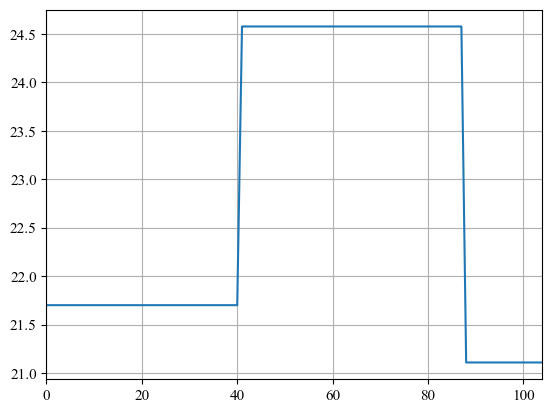

In [2]:
plt.plot(r[:,:,0].T.cpu().detach().numpy())

In [3]:
for idx in range(M):

    print('Test number:', idx)

    data = ([param.to(device) for param in test_set[idx]])
    data_identified = ([param.to(device) for param in test_set_identified[idx]])

    # Create an instance of the NMPC controller (nominal params)
    nmpc = NMPC(2, 2, N, data_identified)

    # Main loop for trajectory iteration
    X[idx,:,0] = y_d[0,0,:]

    for k in range(T):
        print(f"Step {k}, Current State: {X[idx,:,k]}")

        # Call the MPC block to get the optimal control input
        u_optimal = nmpc.optimize_control_sequence(X[idx,:,k], y_d[0, k:k+N+1])

        # Apply the optimal control to the real system dynamics
        X_dot = dynamics(X[idx, :, k], u_optimal, *data)
        X[idx, :, k + 1] = X[idx, :, k] + 1 * X_dot + torch.randn_like(X[idx, :, k], device=device) * .5
        Y[idx, :, k] = X[idx, 0, k] + torch.randn_like(X[idx, 0, k], device=device) * .5

Test number: 0
Step 0, Current State: tensor([20.4954, 40.6414], device='cuda:3')
Step 1, Current State: tensor([21.3420, 41.7647], device='cuda:3')
Step 2, Current State: tensor([22.1737, 41.7714], device='cuda:3')
Step 3, Current State: tensor([21.7311, 43.0973], device='cuda:3')
Step 4, Current State: tensor([21.9810, 42.6944], device='cuda:3')
Step 5, Current State: tensor([22.0969, 42.4667], device='cuda:3')
Step 6, Current State: tensor([21.8367, 42.5794], device='cuda:3')
Step 7, Current State: tensor([21.9665, 42.0824], device='cuda:3')
Step 8, Current State: tensor([21.7068, 41.7787], device='cuda:3')
Step 9, Current State: tensor([22.0552, 42.3024], device='cuda:3')
Step 10, Current State: tensor([22.3074, 43.3353], device='cuda:3')
Step 11, Current State: tensor([22.3121, 42.9137], device='cuda:3')
Step 12, Current State: tensor([21.3311, 43.2345], device='cuda:3')
Step 13, Current State: tensor([22.4545, 43.7546], device='cuda:3')
Step 14, Current State: tensor([21.6354, 43

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

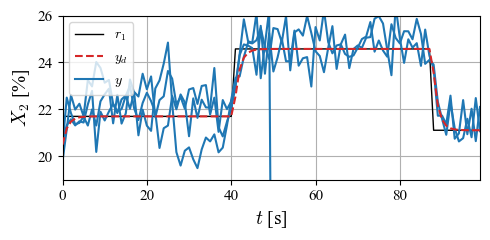

In [4]:
# Plot the reference and the final trajectory
plt.figure(figsize=(10, 6))

plt.figure(figsize=(5, 2.5))
plt.plot(t.cpu().detach().numpy(), r[:, :-N, 0].cpu().detach().T, label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().detach().numpy(), y_d[:, :-N, 0].cpu().detach().T, label="$y_d$", c='tab:red', linestyle='--', zorder=3)
plt.plot(t.cpu().detach().numpy(), Y[:, 0, :].T.cpu().detach(), c='tab:blue', alpha=1, label="no_label")
plt.legend(['$r_1$', '$y_d$', '$y$'], loc='upper left')
# plt.xlim([0, 0.43])
plt.ylim([19, 26])
# plt.tick_params('x', labelbottom=False)
plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$ [%]')
plt.tight_layout()
# plt.savefig("evaporation_evaporation_nmpc_identified.pdf")
plt.show()
# # Plot each state dimension
# plt.subplot(211)
# plt.plot(y_d[0, :, 0].cpu().numpy())
# plt.plot(trajectory[:, 0].cpu().numpy())
# plt.xlabel('Time Step')
# plt.ylabel('State Value')
# # plt.legend()
# plt.grid(True)
#
# # Plot each state dimension
# plt.subplot(212)
# plt.plot(y_d[0, :, 1].cpu().numpy())
# plt.plot(trajectory[:, 1].cpu().numpy())
# plt.xlabel('Time Step')
# plt.ylabel('State Value')
# # plt.legend()
# plt.grid(True)
#
# plt.show()